# Predicting Housing Prices (with Ames Housing Data)
## Part 2 - Feature Selection and Modeling
In this notebook, I will use the datasets prepared in part 1 to conduct modeling and feature selections. 

I will create a few models to test find the model with the best accuracy, try to select a few features to be used to create a production model.

### Contents:
- [Preparing Data](#Preparaing-Data)
- [Model Testing (All Features)](#Model-Testing-with-All-Features)
- [Feature Selection](#Feature-Selection)
- [Model Testing (Selected Features)](#Model-Testing-with-Selected-Features)
- [Production Model](#Production-Model)
- [Housing Insights/Conclusion](#Housing-Insights-and-Conclusion)

# Preparing Data

## Importing Libraries and Datasets

In [1]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
# reading the datasets from part 1
train = pd.read_csv('../datasets/train_cleaned.csv')
test = pd.read_csv('../datasets/test_cleaned.csv')

In [3]:
# checking the shape of the two datasets
print(f'The shape of train dataset after preprocessing: {train.shape}')
print(f'The shape of test dataset after preprocessing: {test.shape}')

The shape of train dataset after preprocessing: (2043, 192)
The shape of test dataset after preprocessing: (879, 191)


## Prepare Training and Testing Dataset

In order to ensure that the models created are accurate, I will create a training and testing dataset. The purpose of these two datasets are:

1. Training dataset - To **train the model**.
2. Testing dataset* - To ensure that the **model is not overfitting to the training data**.

I will use **20% of the dataset as testing data**. This is to ensure that there is sufficient dataset for the models to train on. Furthermore, as I will be using LassoCV, RidgeCV and ElasticNetCV models, these models have **built-in cross-validation functions that checks for overfitting**.

\*Note that this will not be the dataframe called "test", as that dataset does not have the labels and hence cannot be used to check for overfitting or amount of error in the data.

In [4]:
# split the train dataset in X (features) and y (labels)
X = train.drop(columns = 'saleprice').copy()
y = train['saleprice']

In [5]:
# scale all data according to the train dataset and transform the test dataset using the same transformer 
scaler = StandardScaler()
X.loc[:,X.columns] = scaler.fit_transform(X)
test.loc[:,test.columns]  = scaler.transform(test)

In [6]:
# perform train test split on the train dataset using 20% of all data as testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)


# Model Testing with All Features
As mentioned in the part 1, it is observed that **a few features that have high correlation with saleprice**, these include: overall quality, general living area, garage area, total basement square feet. 

As such, a **regularized linear model may be able to predict the housing price with an acceptable degree accuracy**. I will be using linear models to predict the housing price. These models include LinearRegression and linear models with regularization - Lasso, Ridge and ElasticNet. 

The models with regularization will help to ensure that the model do not overfit to the dataset provided as the dataset has a large number of features for a linear regression model.


## Baseline Score
However, before getting into a linear regression model, it will be useful to find out what the baseline score for the dataset is. The baseline score will be obtained by "redicting" any future saleprice using the mean of the saleprice from the training dataset.

The RMSE between the "predicted" saleprice (mean of training dataset saleprice) and the actual saleprice of the testing dataset will be used as the baseline score.

In [7]:
# create a series using the mean saleprice of the training dataset
# number of entries is the same as number of entries of saleprice in testing dataset (y_test)
mean_saleprice = pd.Series(y_train.mean()).repeat(len(y_test))

# calculate and print the baseline RMSE
baseline_rmse = np.sqrt(mean_squared_error(y_test, mean_saleprice))
print(f'The baseline RMSE is {baseline_rmse:.2f}')

The baseline RMSE is 80688.95


The baseline RMSE of 80689 is obtained using just the mean of the saleprice from the training dataset to "predict" the saleprice of property.

This value will be used as a basis to compare the effectiveness of the subsequent models.

## Linear Regression Model

In [8]:
# define a function that create and runs a LinearRegression model
def run_lr_model(X_train, X_test, y_train = y_train, y_test = y_test):
    
    '''
    Takes in X_train, X_test, y_train, y_test
    
    Will print out the R2 score for the training and testing set, as well as the RMSE for the testing set
    
    Return:
    1. List of R2 score of training set, R2 score of testing set and RMSE of testing set
    2. The model that has been trained
    '''
    
    model = LinearRegression()

    model.fit(X_train, y_train)

    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    
    print(f'Linear Regression Statistics')
    print(f'----------------------------')
    print(f'R2 Training Set: {train_r2:.6f}, R2 Testing Set: {test_r2:.6f}')
    print(f'RMSE: {rmse:.2f}')
    
    return [train_r2, test_r2, rmse], model

In [9]:
# run LinearRegression model with all features
all_features_lr, all_features_lr_model = run_lr_model(X_train, X_test)

Linear Regression Statistics
----------------------------
R2 Training Set: 0.928982, R2 Testing Set: -125069090279249335541563392.000000
RMSE: 902278563381126784.00


Results will be evaluated with the other models later.

## Lasso Model

In [10]:
# define a function that create and runs a LassoCV model
def run_lassoCV_model(alpha_list, X_train, X_test, y_train = y_train, y_test = y_test):
    
    '''
    Takes in:
    1. List of alphas the LassoCV model will be trained on
    2. X_train
    3. X_test
    5. y_train (optional, default to y_train)
    6. y_test (optional, default to y_test)
    
    Will print out the alpha chosen for the model, the R2 score for the training and testing set, 
    as well as the RMSE for the testing set
    
    Return:
    1. List of R2 score of training set, R2 score of testing set and RMSE of testing set
    2. The model that has been trained
    '''
    
    model = LassoCV(alphas = alpha_list)

    model.fit(X_train, y_train)

    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    
    print(f'LassoCV Statistics')
    print(f'------------------')
    print(f'Alpha Chosen: {model.alpha_:.6f}')
    print(f'R2 Training Set: {train_r2:.6f}, R2 Testing Set: {test_r2:.6f}')
    print(f'RMSE: {rmse:.2f}')
    
    return [train_r2, test_r2, rmse], model

In [11]:
# initialize a list of alphas to try
alpha_list = np.linspace(270, 310, 800)

# run LassoCV model with all features
all_features_lasso, all_features_lasso_model = run_lassoCV_model(alpha_list, X_train, X_test)

LassoCV Statistics
------------------
Alpha Chosen: 289.173967
R2 Training Set: 0.926415, R2 Testing Set: 0.905644
RMSE: 24782.86


Results will be evaluated with the other models later.

## Ridge Model

In [12]:
# define a function that create and runs a RidgeCV model
def run_ridgeCV_model(alpha_list, X_train, X_test, y_train = y_train, y_test = y_test):
    
    '''
    Takes in:
    1. List of alphas the RidgeCV model will be trained on
    2. X_train
    3. X_test
    5. y_train (optional, default to y_train)
    6. y_test (optional, default to y_test)
    
    Will print out the alpha chosen for the model, the R2 score for the training and testing set, 
    as well as the RMSE for the testing set
    
    Return:
    1. List of R2 score of training set, R2 score of testing set and RMSE of testing set
    2. The model that has been trained
    '''
    
    model = RidgeCV(alphas = alpha_list)

    model.fit(X_train, y_train)

    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    
    print(f'RidgeCV Statistics')
    print(f'------------------')
    print(f'Alpha Chosen: {model.alpha_:.6f}')
    print(f'R2 Training Set: {train_r2:.6f}, R2 Testing Set: {test_r2:.6f}')
    print(f'RMSE: {rmse:.2f}')
    
    return [train_r2, test_r2, rmse], model

In [13]:
# initialize a list of alphas to try
alpha_list = np.linspace(70, 110, 800)

# run RidgeCV model with all features
all_features_ridge, all_features_ridge_model = run_ridgeCV_model(alpha_list, X_train, X_test)

RidgeCV Statistics
------------------
Alpha Chosen: 96.583229
R2 Training Set: 0.927557, R2 Testing Set: 0.905264
RMSE: 24832.66


Results will be evaluated with the other models later.

## ElasticNet Model

In [14]:
# define a function that create and runs a ElasticNetCV model
def run_enetCV_model(alpha_list,  X_train, X_test, l1_ratio_list = 0.5, y_train = y_train, y_test = y_test):
    
    '''
    Takes in:
    1. List of alphas the ElasticNetCV model will be trained on
    2. X_train
    3. X_test
    4. L list of l1 ratios the ElasticNetCV model will be trained on (optional, default to 0.5)
    5. y_train (optional, default to y_train)
    6. y_test (optional, default to y_test)
    
    Will print out the alpha and L1 ratio chosen for the model, the R2 score for the training and testing set, 
    as well as the RMSE for the testing set
    
    Return:
    1. List of R2 score of training set, R2 score of testing set and RMSE of testing set
    2. The model that has been trained
    '''
    
    model = ElasticNetCV(alphas = alpha_list, l1_ratio = l1_ratio_list)

    model.fit(X_train, y_train)

    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    
    print(f'ElasticNetCV Statistics')
    print(f'-----------------------')
    print(f'Alpha Chosen: {model.alpha_:.6f}, L1 Ratio Chosen: {model.l1_ratio_}')
    print(f'R2 Training Set: {train_r2:.6f}, R2 Testing Set: {test_r2:.6f}')
    print(f'RMSE: {rmse:.2f}')
    
    return [train_r2, test_r2, rmse], model

In [15]:
# initialize a list of alphas and l1 ratios to try
# I am limiting the l1 ratios between 0.1 and 0.9 as I do not want the model to converge to either Lasso or Ridge model
alpha_list = np.logspace(-2, 0, 200)
l1_ratio_list = 0.5

# run ElasticNetCV model with all features
all_features_enet, all_features_enet_model = run_enetCV_model(alpha_list, X_train, X_test, l1_ratio_list)

ElasticNetCV Statistics
-----------------------
Alpha Chosen: 0.139871, L1 Ratio Chosen: 0.5
R2 Training Set: 0.927158, R2 Testing Set: 0.905484
RMSE: 24803.75


Results will be evaluated with the other models later.

## Analysis of Results for Models with All Features

In [16]:
# set option so that scientific notation is not used (harder to understand)
pd.set_option('display.float_format', lambda x: '%.7g' % x)

# combine all the r2 scores and rmse from different models into one dataframe
all_features_results = pd.DataFrame({
    'Linear Regression': all_features_lr,
    'Lasso': all_features_lasso,
    'Ridge': all_features_ridge,
    'ElasticNet': all_features_enet
}).T

# reset the index of the datafram
all_features_results.reset_index(inplace=True)

# change the column names of the dataframe
all_features_results.columns = ['Model', 'R2 (Train)', 'R2 (Test)', 'RMSE (Test)']

# add in a column to show which features were used
all_features_results['Features Used'] = 'All Features (191)'

# add in a column to show the percentage improvement over the baseline rmse
all_features_results['Improvement over Baseline (%)'] = round(((baseline_rmse - all_features_results['RMSE (Test)']) / baseline_rmse) * 100, 2)

# display the dataframe with all the results for models with all features 
all_features_results.set_index(['Features Used', 'Model'])

R2 (Train)     R2 (Test)  RMSE (Test)  \
Features Used      Model                                                      
All Features (191) Linear Regression    0.928982 -1.250691e+26 9.022786e+17   
                   Lasso               0.9264148     0.9056436     24782.86   
                   Ridge               0.9275574      0.905264     24832.66   
                   ElasticNet          0.9271582     0.9054844     24803.75   

                                      Improvement over Baseline (%)  
Features Used      Model                                             
All Features (191) Linear Regression                  -1.118218e+15  
                   Lasso                                      69.29  
                   Ridge                                      69.22  
                   ElasticNet                                 69.26

**Linear Regression Model**

From the above results, it is obvious that LinearRegression performed the worst. In fact, it performed much worse than even the baseline model, with an astronomical RMSE figure, indicating that the errors are extremely huge. I will explore the coefficients of the Linear Regression model for better understanding.

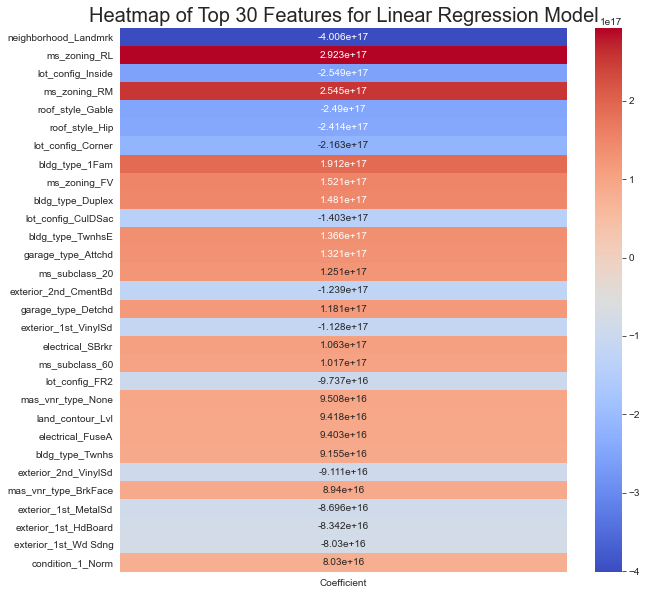

In [17]:
# create a dataframe of the coefficient of all from the Linear Regression model 
# sorted by the absolute values of the coefficients
all_features_lr_coef_df = pd.DataFrame(list(all_features_lr_model.coef_), index = X_train.columns, columns = ['Coefficient'])
all_features_lr_coef_df['abs_coef'] = abs(all_features_lr_coef_df['Coefficient'])
all_features_lr_coef_df = all_features_lr_coef_df.sort_values('abs_coef', ascending = False)

# create a heatmap of the top 30 coefficients
plt.figure(figsize = (10, 10))
sns.heatmap(all_features_lr_coef_df[['Coefficient']][:30], annot = True, fmt = '.4g', cmap = 'coolwarm')
plt.title('Heatmap of Top 30 Features for Linear Regression Model', fontsize = 20)
plt.show()

The heatmap of the top 30 highest coefficient features from the Linear Regression model shows that the **coefficients are extremely overblown**. For example, from the heatmap, being in a Residential Low Density (ms_zoning_RL) increases the value of a property by 290,000 trillion dollars!

This shows that the model is highly overfitted to the training dataset, evident from the good R2 score of 0.929 from the training dataset and the R2 score of -1.25 * 10^26 of the testing dataset. This shows that the **model is not useful in explaining the variance** of the target. This is not surprising as with the **huge amount of features** given to the model, the Linear Regression model (which has no regularization) will end up creating a model that is **overly complex and overfitted to the dataset** it is trained on.

In [18]:
# display the dataframe with all the results for models with all features 
all_features_results.set_index(['Features Used', 'Model'])

R2 (Train)     R2 (Test)  RMSE (Test)  \
Features Used      Model                                                      
All Features (191) Linear Regression    0.928982 -1.250691e+26 9.022786e+17   
                   Lasso               0.9264148     0.9056436     24782.86   
                   Ridge               0.9275574      0.905264     24832.66   
                   ElasticNet          0.9271582     0.9054844     24803.75   

                                      Improvement over Baseline (%)  
Features Used      Model                                             
All Features (191) Linear Regression                  -1.118218e+15  
                   Lasso                                      69.29  
                   Ridge                                      69.22  
                   ElasticNet                                 69.26

**Models with Regularization**

For the three models with regularization - Lasso, Ridge and ElasticNet. All three models performed much better than the baseline score. All three models saw an **improvement in RMSE over the baseline RMSE of almost 70%** and show evidence of **no overfitting** as the R2 score using the test set are all above 0.905.

1. Lasso - The Lasso model performed the best among all three models. This is perhaps because there are many redundant features in the 191 features chosen and the Lasso model is able to set coefficient of redundant features to 0, totally removing their effects.
2. Ridge - The Ridge model performed the worst among all three models, that said, their performances are very similar. The reason why Ridge did not perform as well as Lasso could be due to the fact that the Ridge model is only able to penalize the coefficient to be low, but never reaching 0. Hence, allowing some additional errors to arise.
3. ElasticNet - Expectedly, the ElasticNet model performed between the Lasso and Ridge model. This should be because the model carries out both L1 and L2 regularization, hence, it performs slightly better than the pure Ridge model as it can set the coefficient of some features to 0, while performing slightly worse than the pure Lasso model as it will tend to not set some coefficient to 0 when it could be 0.

Overall, **all the models with regularization performed well**, with the **Lasso model performing slightly better** than the other two models.

# Feature Selection

From the above, we can see that if we pass in all the features, the model can perform quite well as long as regularization is applied to prevent overfitting.

Practically speaking, collecting data can be a difficult and costly process. Reducing the number of features to be used in the models not only help to prevent overfitting but will also reduce the efforts and budget needed for data collection.

In this section, I will choose 30 features to be used to generate a model. These 30 features should be the best predictor of saleprice.

## Ranking Features Using LassoCV 

In [19]:
# create a dataframe with the feature names and the coefficient of each features given by the lasso model
lasso_ranking = pd.DataFrame(list(zip(X_train.columns, all_features_lasso_model.coef_)), 
                             columns = ['features', 'lasso_coef'])

# create a new column that takes the absolute of the coefficient of features from the lasso model
# as having a high negative coefficient means that feature is also an excellent predictor of the target
lasso_ranking['abs_lasso_coef'] = abs(lasso_ranking['lasso_coef'])

# sort the dataframe based on the absolute coefficient of features
lasso_ranking = lasso_ranking.sort_values('abs_lasso_coef', ascending=False).reset_index(drop=True)

# create a list of the top 30 features
top_30_features_lasso = lasso_ranking[:30]['features'].to_list()

## Ranking Features Using RidgeCV 

In [20]:
# create a dataframe with the feature names and the coefficient of each features given by the ridge model
ridge_ranking = pd.DataFrame(list(zip(X_train.columns, all_features_ridge_model.coef_)), 
                             columns = ['features', 'ridge_coef'])

# create a new column that takes the absolute of the coefficient of features from the ridge model
ridge_ranking['abs_ridge_coef'] = abs(ridge_ranking['ridge_coef'])

# sort the dataframe based on the absolute coefficient of features
ridge_ranking = ridge_ranking.sort_values('abs_ridge_coef', ascending=False).reset_index(drop=True)

# create a list of the top 30 features
top_30_features_ridge = ridge_ranking[:30]['features'].to_list()

## Determining Exact Features to Use

With the top 30 features chosen by the LassoCV and RidgeCV model, I can cross check which features are in both lists, these features should be very impactful in understand the target. 

I will also explore the features that only appear in one of the lists and make further selection from these.

In [21]:
# initialize 3 empty list

# one list for features that are in both the top 30 lists from both LassoCV and RidgeCV
top_30_lasso_and_ridge = []

# one list for features that are only in the top 30 list from LassoCV
top_30_lasso_not_ridge = []

# one list for features that are only in the top 30 list from RidgeCV
top_30_ridge_not_lasso = []


# append features that are in both lists into the top_30_lasso_and_ridge list
for feature in top_30_features_lasso:
    if feature in top_30_features_ridge:
        top_30_lasso_and_ridge.append(feature)
        
# append features that are only in the top 30 list from LassoCV into the top_30_lasso_not_ridge list
for feature in top_30_features_lasso:
    if feature not in top_30_features_ridge:
        top_30_lasso_not_ridge.append(feature)
        
# append features that are only in the top 30 list from RidgeCV into the top_30_ridge_not_lasso list
for feature in top_30_features_ridge:
    if feature not in top_30_features_lasso:
        top_30_ridge_not_lasso.append(feature)

As I will be using a linear regression model, **features with high correlation with the target** should be more useful in predicting the target as compared to one with lower correlation figure. Hence, I will look at the correlation between the features and the targets and pick the features with the highest correlations.

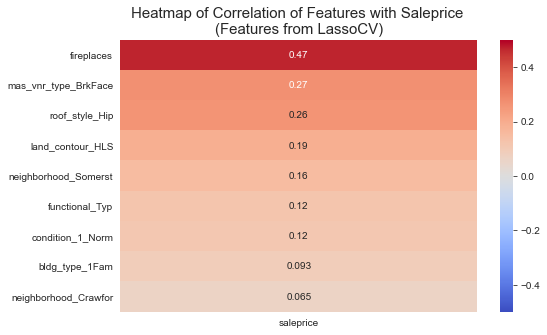

In [22]:
# create a new dataframe with the features that are ONLY in the top 30 features from LassoCV 
# and concat it to the target (saleprice) to generate a correlation table
top_30_lasso_df = pd.concat([X_train[top_30_lasso_not_ridge], y_train], axis = 1)

# create a heatmap of the correlation of the features with saleprice
plt.figure(figsize = (8, 5))
sns.heatmap(top_30_lasso_df.corr()[['saleprice']].sort_values('saleprice', ascending=False)[1:],  cmap = 'coolwarm', annot = True, vmin = -.5, vmax = .5)
plt.title('Heatmap of Correlation of Features with Saleprice \n(Features from LassoCV)', fontsize = 15)
plt.show()

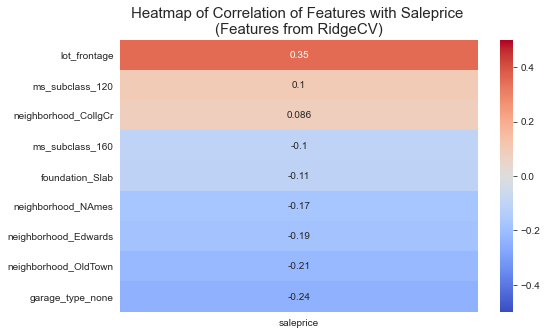

In [23]:
# create a new dataframe with the features that are ONLY in the top 30 features from LassoCV 
# and concat it to the target (saleprice) to generate a correlation table
top_30_ridge_df = pd.concat([X_train[top_30_ridge_not_lasso], y_train], axis = 1)

# create a heatmap of the correlation of the features with saleprice
plt.figure(figsize = (8, 5))
sns.heatmap(top_30_ridge_df.corr()[['saleprice']].sort_values('saleprice', ascending=False)[1:],  cmap = 'coolwarm', annot = True, vmin = -.5, vmax = .5)
plt.title('Heatmap of Correlation of Features with Saleprice \n(Features from RidgeCV)', fontsize = 15)
plt.show()

### Adding Features with High Correlation with Saleprice
From the two plot above, the features mas_vnr_type_BrkFace, neighborhood_Somerst, land_contour_HLS, roof_style_Hip, fireplaces, neighborhood_NAmes, neighborhood_OldTown, garage_type_none, lot_frontage and neighborhood_Edwards are chosen as these features are in the **top 30 features of either the LassoCV or RidgeCV model** and they also have **higher correlation with saleprice as compared to other features available** (absolute correlation > 0.2).

These features will be combined with the features that were previously in BOTH top 30 features list of LassoCV and RidgeCV to make a list of selected features.

In [24]:
# create a new list, initialize it with the features that were previously in both top 30 features list
selected_features = top_30_lasso_and_ridge.copy()

# append the features we have identified above into the selected features list
for feature in 'fireplaces, mas_vnr_type_BrkFace, roof_style_Hip, lot_frontage, garage_type_none, neighborhood_OldTown'.replace(' ', '').split(','):
    selected_features.append(feature)

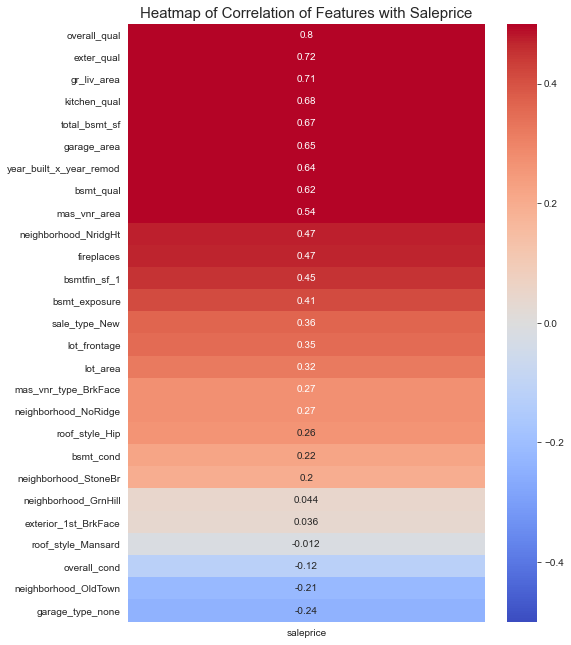

In [25]:
# create a new dataframe with the selected features and concat it to the target (saleprice) to generate a correlation table
selected_features_df = pd.concat([X_train[selected_features], y_train], axis = 1)

# create a heatmap of the correlation of the features with saleprice
plt.figure(figsize = (8, 11))
sns.heatmap(selected_features_df.corr()[['saleprice']].sort_values('saleprice', ascending=False)[1:],  cmap = 'coolwarm', annot = True, vmin = -.5, vmax = .5)
plt.title('Heatmap of Correlation of Features with Saleprice', fontsize = 15)
plt.show()

### Dropping Features with Low Correlation with Saleprice
It is surprising to find 3 features with **very low correlation to saleprice** as these features were features with 30 highest coefficient from both LassoCV and RidgeCV. These features are neighborhood_GrnHill, exterior_1st_BrkFace and roof_style_Mansard. 

However, due to the low correlation with saleprice, these features will be dropped from the list of selected features.

In [26]:
# dropping the features identified above
selected_features.remove('neighborhood_GrnHill')
selected_features.remove('exterior_1st_BrkFace')
selected_features.remove('roof_style_Mansard')

In [27]:
selected_features

['gr_liv_area',
 'overall_qual',
 'bsmtfin_sf_1',
 'neighborhood_NridgHt',
 'total_bsmt_sf',
 'mas_vnr_area',
 'year_built_x_year_remod',
 'exter_qual',
 'garage_area',
 'bsmt_exposure',
 'neighborhood_StoneBr',
 'overall_cond',
 'kitchen_qual',
 'lot_area',
 'sale_type_New',
 'neighborhood_NoRidge',
 'bsmt_qual',
 'bsmt_cond',
 'fireplaces',
 'mas_vnr_type_BrkFace',
 'roof_style_Hip',
 'lot_frontage',
 'garage_type_none',
 'neighborhood_OldTown']

In [28]:
# number of features selected
print(f'Out of 191 features, {len(selected_features)} features are selected')

Out of 191 features, 24 features are selected


# Model Testing with Selected Features

## Linear Regression Model

In [29]:
# run LinearRegression model with the selected features
selected_features_lr, selected_features_lr_model = run_lr_model(X_train[selected_features], X_test[selected_features])

Linear Regression Statistics
----------------------------
R2 Training Set: 0.904043, R2 Testing Set: 0.900030
RMSE: 25509.37


Results will be evaluated with the other models later.

## Lasso Model

In [30]:
# initialize a list of alphas to try
alpha_list = np.logspace(-6, 3, 800)

# run LassoCV model with selected features
selected_features_lasso, selected_features_lasso_model = run_lassoCV_model(alpha_list, X_train[selected_features], X_test[selected_features])

LassoCV Statistics
------------------
Alpha Chosen: 0.000001
R2 Training Set: 0.904043, R2 Testing Set: 0.900030
RMSE: 25509.37


Results will be evaluated with the other models later.

## Ridge Model

In [31]:
# initialize a list of alphas to try
alpha_list = np.linspace(20, 60, 800)

# run RidgeCV model with selected features
selected_features_ridge, selected_features_ridge_model = run_ridgeCV_model(alpha_list, X_train[selected_features], X_test[selected_features])

RidgeCV Statistics
------------------
Alpha Chosen: 34.067584
R2 Training Set: 0.903969, R2 Testing Set: 0.900032
RMSE: 25509.12


Results will be evaluated with the other models later.

## ElasticNet Model

In [32]:
# initialize a list of alphas and l1 ratios to try
alpha_list = np.logspace(-3, 3, 200)
l1_ratio_list = 0.5

# run ElasticNetCV model with selected features
selected_features_enet, selected_features_enet_model = run_enetCV_model(alpha_list, X_train[selected_features], X_test[selected_features], l1_ratio_list)

ElasticNetCV Statistics
-----------------------
Alpha Chosen: 0.052311, L1 Ratio Chosen: 0.5
R2 Training Set: 0.903928, R2 Testing Set: 0.900009
RMSE: 25512.10


Results will be evaluated with the other models later.

## Analysis of Results for Models with Selected Features

In [33]:
# set option so that scientific notation is not used (harder to understand)
pd.set_option('display.float_format', lambda x: '%.7g' % x)

# combine all the r2 scores and rmse from different models into one dataframe
selected_features_results = pd.DataFrame({
    'Linear Regression': selected_features_lr,
    'Lasso': selected_features_lasso,
    'Ridge': selected_features_ridge,
    'ElasticNet': selected_features_enet
}).T

# reset the index of the datafram
selected_features_results.reset_index(inplace=True)

# change the column names of the dataframe
selected_features_results.columns = ['Model', 'R2 (Train)', 'R2 (Test)', 'RMSE (Test)']

# add in a column to show which features were used
selected_features_results['Features Used'] = 'Selected Features (24)'

# add in a column to show the percentage improvement over the baseline rmse
selected_features_results['Improvement over Baseline (%)'] = round(((baseline_rmse - selected_features_results['RMSE (Test)']) / baseline_rmse) * 100, 2)

# combine the results from both models with all features and selected features
all_results = pd.concat([all_features_results, selected_features_results])

# display the dataframe with all the results for models with all features 
all_results.set_index(['Features Used', 'Model'])

R2 (Train)     R2 (Test)  \
Features Used          Model                                         
All Features (191)     Linear Regression    0.928982 -1.250691e+26   
                       Lasso               0.9264148     0.9056436   
                       Ridge               0.9275574      0.905264   
                       ElasticNet          0.9271582     0.9054844   
Selected Features (24) Linear Regression   0.9040428     0.9000304   
                       Lasso               0.9040428     0.9000304   
                       Ridge               0.9039686     0.9000323   
                       ElasticNet          0.9039284     0.9000089   

                                          RMSE (Test)  \
Features Used          Model                            
All Features (191)     Linear Regression 9.022786e+17   
                       Lasso                 24782.86   
                       Ridge                 24832.66   
                       ElasticNet            24803.75   
Selected Features (24) Linear Regression     25509.37   
                       Lasso                 25509.37   
                       Ridge                 25509.12   
                       ElasticNet             25512.1   

                                          Improvement over Baseline (%)  
Features Used          Model                                             
All Features (191)     Linear Regression                  -1.118218e+15  
                       Lasso                                      69.29  
                       Ridge                                      69.22  
                       ElasticNet                                 69.26  
Selected Features (24) Linear Regression                          68.39  
                       Lasso                                      68.39  
                       Ridge                                      68.39  
                       ElasticNet                                 68.38

From the table above, with the selected features, **all 4 linear regression models** - Linear Regression, Lasso, Ridge and ElasticNet, **performed almost equally well**, having:
1. R2 score on training dataset of around 0.904
2. R2 score on testing dataset of around 0.900
3. RMSE score of around 25509 (with ElasticNet doing the worst at 25511)

\
**Observations**
--------------------------

**1. No Overfitting**

The similarly high **R2 scores of around 0.9 achieved on both the training dataset** (which itself is a cross-validated score) **and the testing dataset** (which is an unseen dataset for the model) shows that the model is **generalizing very well to the data and is not overfitting**.


\
**2. Selected Features are Good Predictors**

The **RMSE achieved by the Linear Regression model as low as RMSE achieved by models with regularization** and has improved drastically from the RMSE achieved when all features was used. This indicates that:
1. There is **no overfitting due to having too many features**.
2. **All selected features are important to predicting the saleprice**, evident from the similar RMSE with models with regularization. If any feature is redundant, Ridge or Lasso would potentially have a lower RMSE than that achieved by Linear Regression. This is further supported by optimal alpha chosen by the LassoCV model to be 0.000001 which is the lowerbound of the list of alphas given, suggesting that there is perhaps no need for L2 regularization.


\
**3. Minimal Decrease in Performance with Selected Features**

With the 24 selected features, the best model (Ridge) achieved a 68.39% improvement against the baseline RMSE. On the other hand, with all 191 features, the best model (Lasso) achieved a 69.22% improvement against the baseline RMSE. **Dropping 167 features resulted in only less than 1% decrease in the improvement against the baseline RMSE**. 

For the purpose of this project, the **1% increase in improvement over the baseline RMSE is not worth the effort and cost needed to collected data for 167 more features**. Hence, the best model will be chosen from the models with the 24 selected features.

\
**Model Chosen as Production Model**
-----------------------

The **Ridge model** will be chosen as the production model. The reason for this choice is that:
1. It has **slightly higher R2 score** on the test dataset - Shows that this model generalizes slightly better
2. It has **slightly higher RMSE score** - Shows that performs slightly better

# Production Model

For the production model, instead of the datasets that have been split using train_test_split. I will instead use the **full dataset** (X and y instead X_train and y_train) to train the model. This will help to ensure that the model sees all the available data, instead of 80% of the data, and generalizes better to new data.

In [34]:
# initializez a Ridge model with optimal alpha as found from RidgeCV above
ridge_model = Ridge(alpha = 34.067584)

# fit the ridge model to the entire train dataset
ridge_model = ridge_model.fit(X[selected_features], y)

# find the R2 score and the cross validated RMSE of the model
ridge_model_r2 = ridge_model.score(X[selected_features], y)
ridge_model_cv_rmse = -cross_val_score(ridge_model, X[selected_features], y, scoring = 'neg_root_mean_squared_error', cv=5)

# print out the R2 score and RMSE found
print(f'Production Model Statistics')
print(f'---------------------------')
print(f'R2 Score: {ridge_model_r2:.6f}, Cross Validated RMSE: {ridge_model_cv_rmse.mean():.2f}')

Production Model Statistics
---------------------------
R2 Score: 0.903820, Cross Validated RMSE: 25130.57


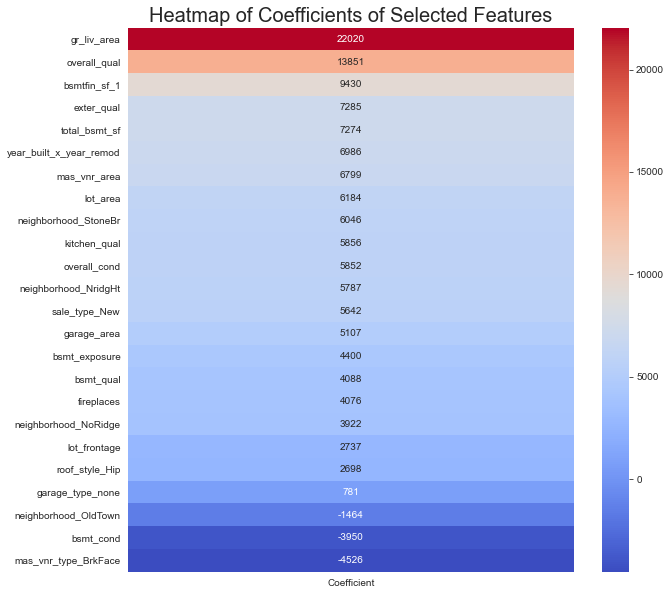

In [35]:
# create a dataframe of the selected features and their respective coefficients from the production ridge model (sorted)
model_feature_coef = pd.DataFrame(list(ridge_model.coef_), index = selected_features, columns = ['Coefficient'])
model_feature_coef = model_feature_coef.sort_values('Coefficient', ascending = False)

# create a heatmap of the coefficients of the selected features and their respective coefficient
plt.figure(figsize = (10, 10))
sns.heatmap(model_feature_coef[['Coefficient']], annot = True, fmt = '.0f', cmap = 'coolwarm')
plt.title('Heatmap of Coefficients of Selected Features', fontsize = 20)
plt.show()

# Housing Insights and Conclusion
With the model generated, the rough range of a property can be predicted as a reference to ensure that a potential home buyer or home seller is not tricked into buying or selling at inappropriate prices. The predicted saleprice can also be used as a basis for the start of negotiation and bargaining of the prices, however, user should note that the generalized error is around 20,000 dollars, so do allow some room for negotiation.

From the above, we can also learn that the most important features to determining the saleprice of a property are: **area (in square feet), quality and condition of the property, when the property was built/remod (if applicable), and the neighborhood** of the property. Other observations:
1. The features that have the largest impact to the saleprice of a house is the **area of above ground living area, the overall quality and the area of basement**, this is not surprising as home with larger living areas and better quality should logically command a higher price. 
2. Apart from the overall quality, the **quality of exterior material and kitchen** can be a good determinant of the saleprice as well. This could be because new homeowners may not want to do renovation to these areas, allowing the properties with good quality existing exterior material and kitchen to command a higher price. 
3. The **neighborhood of the property** also have huge effect on the saleprice. For example, a property in **Stone Brook can command an additional 6000 dollars** in general, while a property in **Old Town will potentially reduce the saleprice by 1500 dollars** in general. This could be due to the development of the estate.

For a homeowner who wish to sell their property, properties like the area, neighborhood or age are relatively hard to change. However, **some possible things that homeowners can do to increase their home values** will include **things that improve the quality of their homes**, such as:
1. repairing any defects in the house, repainting the house --> improve the overall material and finish quality
2. repairing/upgrading the exterior material --> improve exterior material quality
3. repairing/renovating/upgrading the kitchen --> improve kitchen quality
4. adding a fireplace if there is none

**Limitations**
1. As mentioned previously, the model should only be used as a reference. The average error of the model on dataset collected around the same time period is about 20,000 dollars and the model only accounts for 90% of the variations in saleprice. This indicates that there are other factors that affects the saleprice that is currently not accounted by the model. 
2. The data used is between 2006 to 2010. It may not fit well to present-day data due to inflation. The period of data is also relatively short, hence, may not be as accurate in predicting present-day data.
3. The model may have even lower accuracy for predicting property prices in other locations. This is evident as some important features in predicting the saleprice are specific location in Ames, USA. Furthermore, these properties to Singapore, there are also huge differences in the type of features needed. For example, in Singapore, most people stays in HDBs which do not have features such as garage or basement, and with Singapore's climate, a fireplace is not useful or necessary. 

**To make the model more universal**
1. **Features that are location specific should be removed**. These include features such as neighborhood.
2. **Data from a longer period of time should be obtained**. This not only checks if the prices are well generalized, but may also allow the model to spot trends in the different years, allowing for a more accurate model.
3. **Local culture of the target location** should be accounted for. For example, as mentioned, housing data in Singapore would be vastly different from the housing data we have explored due to the difference in housing options and features needed. A new model should be trained if the target location varies too heavily.

# Making Submission Files

In [36]:
# define a function to make submission files
# NOTE: code is commented out, please remove comment below to run if necessary
# def make_submission(model, df_test, filename):
    
#     df = pd.read_csv('../datasets/test.csv')
#     submission = df[['Id']].copy()
#     submission['SalePrice'] = model.predict(df_test)
#     submission.to_csv('../datasets/' + filename + '.csv', index = False)

In [37]:
# make a submission file using LassoCV model trained on all features
# NOTE: code is commented out, please remove comment below to run if necessary
# make_submission(all_features_lasso_model, test, 'submission_lasso_all_features')

In [38]:
# make a submission file using RidgeCV model trained on all features
# NOTE: code is commented out, please remove comment below to run if necessary
# make_submission(all_features_ridge_model, test, 'submission_ridge_all_features')

In [39]:
# make a submission file using LassoCV model trained on selected features
# NOTE: code is commented out, please remove comment below to run if necessary
# make_submission(selected_features_lasso_model, test[selected_features], 'submission_lasso_selected_features')

In [40]:
# make a submission file using RidgeCV model trained on selected features
# NOTE: code is commented out, please remove comment below to run if necessary
# make_submission(selected_features_ridge_model, test[selected_features], 'submission_ridge_selected_features')

In [41]:
# make a submission file using Ridge production model trained on selected features
# NOTE: code is commented out, please remove comment below to run if necessary
# make_submission(ridge_model, test[selected_features], 'submission_production_model_ridge_selected_features')